In [1]:
!pip install torchmetrics timm
import gc
import numpy as np
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets, models, transforms
import torch
from matplotlib import pyplot as plt
from tensorflow import keras
from cv2 import imread
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import torchmetrics 
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn
from torch.optim import AdamW,Adam # optmizers
import time
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 9.3 MB/s eta 0:00:00a 0:00:01


# 데이터

In [2]:
label = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/fixed_labels_v2.csv")
label

,filename,old_label,new_label
0,10.jpg,Type_2,Type_1
1,1001.jpg,Type_2,Type_1
2,1002.jpg,Type_3,Type_2
3,1004.jpg,Type_2,Type_1
4,1005.jpg,Type_3,Type_1
...,...,...,...
1816,975.jpg,Type_2,Type_1
1817,984.jpg,Type_2,Type_3
1818,986.jpg,Type_2,Type_1
1819,988.jpg,Type_2,Type_1


In [3]:
root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
train_dir = os.path.join(root_dir,'train', 'train')

type1_dir = os.path.join(train_dir, 'Type_1')
type2_dir = os.path.join(train_dir, 'Type_2')
type3_dir = os.path.join(train_dir, 'Type_3')

train_type1_files = glob.glob(type1_dir+'/*.jpg')
train_type2_files = glob.glob(type2_dir+'/*.jpg')
train_type3_files = glob.glob(type3_dir+'/*.jpg')

added_type1_files  =  glob.glob(os.path.join(root_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(root_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(root_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')


type1_files = train_type1_files + added_type1_files
type2_files = train_type2_files + added_type2_files
type3_files = train_type3_files + added_type3_files

print(f'''Type 1 files for training: {len(type1_files)} 
Type 2 files for training: {len(type2_files)}
Type 3 files for training: {len(type3_files)}''' )

Type 1 files for training: 1441 
Type 2 files for training: 4348
Type 3 files for training: 2426


In [4]:
files = {'filepath': type1_files + type2_files + type3_files,
          'label': ['Type 1']* len(type1_files) + ['Type 2']* len(type2_files) + ['Type 3']* len(type3_files)}

files_df = pd.DataFrame(files).sample(frac=1, random_state= 1).reset_index(drop=True)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8211,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8212,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8213,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


In [5]:
bad_files = []
for path in tqdm(files_df['filepath'].values):
    try:
        img = Image.open(path)
    except:
        index = files_df[files_df['filepath']==path].index.values[0]
        bad_files.append(index)

100%|██████████| 8215/8215 [03:12<00:00, 42.75it/s]


In [6]:
bad_files
files_df.drop(bad_files, inplace=True)

In [7]:
# save csv (files_df)
#files_df.to_csv('/kaggle/working/dropfiles.csv', sep=',')

In [8]:
# 정리된 files_df 사용
#files_df = pd.read_csv('../input/dropfiles/dropfiles.csv', sep=',').drop('Unnamed: 0', axis=1)
#files_df

In [9]:
# get count of each type 
type_count = pd.DataFrame(files_df['label'].value_counts()).rename(columns= {'label': 'Num_Values'})
type_count

,Num_Values
Type 2,4346
Type 3,2426
Type 1,1440


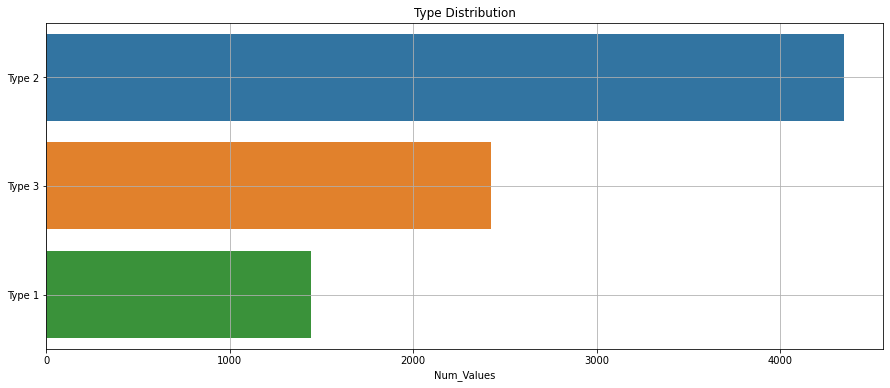

In [10]:
plt.figure(figsize = (15, 6))
sns.barplot(x= type_count['Num_Values'], y= type_count.index.to_list())
plt.title('Type Distribution')
plt.grid(True)
plt.show()

In [11]:
pie_plot = go.Pie(labels= type_count.index.to_list(), values= type_count.values.flatten(),
                 hole= 0.2, text= type_count.index.to_list(), textposition='auto')
fig = go.Figure([pie_plot])
fig.update_layout(title_text='Pie Chart of Type Distribution')
fig.show()

# 데이터 분리

In [12]:
# Train / Validation

train_df, valid_df = train_test_split(files_df, test_size = 0.2, stratify = files_df['label'], random_state = 1234)

print(len(train_df), len(valid_df))

6569 1643


In [13]:
X_train = train_df[['filepath']]
y_train = train_df[['label']]
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [14]:
X_valid = valid_df[['filepath']].reset_index(drop=True)
y_valid = valid_df[['label']].reset_index(drop=True)

print(len(X_train), len(y_train), len(X_valid),len(y_valid))

6569 6569 1643 1643


# 데이터 전처리

In [15]:
# save train data as npy files

#np.save('/kaggle/working/X_train_25', X_train)
#np.save('/kaggle/working/y_train_25', y_train)

In [16]:
features = []
f_app = features.append
path = train_df['filepath'].values
labels = train_df['label'].values
for p in tqdm(path):
    image = cv2.imread(p)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    re_image = cv2.resize(image, (224,224))
    f_app(np.array(re_image))

X_train = np.array(features)
y_train = np.array(labels)

100%|██████████| 6569/6569 [22:10<00:00,  4.94it/s]


In [17]:
# 소요시간줄이는코드 (추가 수정 필요)
#path = train_df['filepath'].values
#labels = train_df['label'].values
#features = [np.array(cv2.resize(cv2.cvtColor(cv2.imread(p),cv2.COLOR_RGB2BGR),(180,180))) for p in tqdm(path)]

In [18]:
# validation data

features = []
f_app = features.append
path = valid_df['filepath'].values
labels = valid_df['label'].values
for p in tqdm(path):
    image = cv2.imread(p)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    re_image = cv2.resize(image, (224,224))
    f_app(np.array(re_image))

X_valid = np.array(features)
y_valid = np.array(labels)

100%|██████████| 1643/1643 [05:22<00:00,  5.09it/s]


In [19]:
# save validation data as npy files

#np.save('/kaggle/working/X_valid', X_valid)
#np.save('/kaggle/working/y_valid', y_valid)

In [20]:
# X train data 확인
X_train[0]

array([[[ 64,  79,  86],
        [ 72,  85,  93],
        [ 70,  81,  87],
        ...,
        [ 90,  56,  81],
        [ 84,  52,  75],
        [ 91,  59,  83]],

       [[ 69,  79,  86],
        [ 78,  87,  92],
        [ 81,  90,  97],
        ...,
        [ 93,  59,  84],
        [ 92,  57,  82],
        [ 90,  57,  80]],

       [[ 76,  83,  93],
        [ 79,  86,  94],
        [ 85,  92,  98],
        ...,
        [ 97,  63,  90],
        [ 94,  60,  87],
        [ 92,  59,  85]],

       ...,

       [[111,  75, 101],
        [109,  75, 102],
        [ 92,  58,  85],
        ...,
        [ 62,  31,  46],
        [ 62,  33,  51],
        [ 71,  42,  62]],

       [[120,  84, 110],
        [109,  73, 101],
        [ 99,  66,  92],
        ...,
        [ 60,  29,  45],
        [ 69,  37,  59],
        [ 74,  43,  69]],

       [[124,  88, 114],
        [117,  81, 107],
        [110,  76, 101],
        ...,
        [ 68,  36,  57],
        [ 81,  49,  73],
        [ 84,  51,  80]]

In [21]:
# X validation data 확인
X_valid[0]

array([[[ 53,  51,  68],
        [ 56,  47,  67],
        [ 55,  48,  64],
        ...,
        [ 22,  30,  37],
        [ 22,  33,  39],
        [ 30,  34,  43]],

       [[ 59,  52,  71],
        [ 61,  54,  72],
        [ 59,  48,  67],
        ...,
        [ 25,  35,  44],
        [ 24,  31,  42],
        [ 28,  33,  44]],

       [[ 64,  57,  74],
        [ 61,  54,  72],
        [ 67,  58,  77],
        ...,
        [ 29,  44,  51],
        [ 27,  39,  47],
        [ 24,  34,  43]],

       ...,

       [[ 65,  64,  84],
        [ 77,  70,  93],
        [ 93,  85, 109],
        ...,
        [ 53,  40,  57],
        [ 50,  37,  54],
        [ 51,  37,  55]],

       [[ 53,  50,  71],
        [ 64,  56,  79],
        [ 70,  62,  85],
        ...,
        [ 54,  41,  61],
        [ 49,  38,  55],
        [ 48,  35,  52]],

       [[ 40,  42,  62],
        [ 51,  47,  68],
        [ 60,  56,  77],
        ...,
        [ 49,  36,  56],
        [ 49,  36,  56],
        [ 48,  36,  52]]

In [22]:
# 정규화 (0과1사이의값)
X_train = X_train/255
X_valid = X_valid/255

In [23]:
# 정규화한 X train data 확인
X_train[0]

array([[[0.25098039, 0.30980392, 0.3372549 ],
        [0.28235294, 0.33333333, 0.36470588],
        [0.2745098 , 0.31764706, 0.34117647],
        ...,
        [0.35294118, 0.21960784, 0.31764706],
        [0.32941176, 0.20392157, 0.29411765],
        [0.35686275, 0.23137255, 0.3254902 ]],

       [[0.27058824, 0.30980392, 0.3372549 ],
        [0.30588235, 0.34117647, 0.36078431],
        [0.31764706, 0.35294118, 0.38039216],
        ...,
        [0.36470588, 0.23137255, 0.32941176],
        [0.36078431, 0.22352941, 0.32156863],
        [0.35294118, 0.22352941, 0.31372549]],

       [[0.29803922, 0.3254902 , 0.36470588],
        [0.30980392, 0.3372549 , 0.36862745],
        [0.33333333, 0.36078431, 0.38431373],
        ...,
        [0.38039216, 0.24705882, 0.35294118],
        [0.36862745, 0.23529412, 0.34117647],
        [0.36078431, 0.23137255, 0.33333333]],

       ...,

       [[0.43529412, 0.29411765, 0.39607843],
        [0.42745098, 0.29411765, 0.4       ],
        [0.36078431, 0

In [24]:
# 정규화한 X validation data 확인
X_valid[0]

array([[[0.20784314, 0.2       , 0.26666667],
        [0.21960784, 0.18431373, 0.2627451 ],
        [0.21568627, 0.18823529, 0.25098039],
        ...,
        [0.08627451, 0.11764706, 0.14509804],
        [0.08627451, 0.12941176, 0.15294118],
        [0.11764706, 0.13333333, 0.16862745]],

       [[0.23137255, 0.20392157, 0.27843137],
        [0.23921569, 0.21176471, 0.28235294],
        [0.23137255, 0.18823529, 0.2627451 ],
        ...,
        [0.09803922, 0.1372549 , 0.17254902],
        [0.09411765, 0.12156863, 0.16470588],
        [0.10980392, 0.12941176, 0.17254902]],

       [[0.25098039, 0.22352941, 0.29019608],
        [0.23921569, 0.21176471, 0.28235294],
        [0.2627451 , 0.22745098, 0.30196078],
        ...,
        [0.11372549, 0.17254902, 0.2       ],
        [0.10588235, 0.15294118, 0.18431373],
        [0.09411765, 0.13333333, 0.16862745]],

       ...,

       [[0.25490196, 0.25098039, 0.32941176],
        [0.30196078, 0.2745098 , 0.36470588],
        [0.36470588, 0

In [25]:
# train 개수, 차원 확인
print(len(X_train), len(y_train))
print(X_train.shape)

6569 6569
(6569, 224, 224, 3)


In [26]:
# validation 개수, 차원 확인
print(len(X_valid), len(y_valid))
print(X_valid.shape)

1643 1643
(1643, 224, 224, 3)


In [27]:
# y 라벨링 (string -> int)
le = LabelEncoder().fit(['Type 1', 'Type 2', 'Type 3'])
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

y_train_onehot = to_categorical(y_train, num_classes=3)
y_valid_onehot = to_categorical(y_valid, num_classes=3)

In [28]:
y_train_onehot[:5]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [29]:
y_valid_onehot[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [30]:
import tensorflow as tf



class conv_block(tf.keras.Model):
    def __init__(self, filters, strides=(2, 2)):
        super(conv_block, self).__init__()

        self.filters1, self.filters2, self.filters3 = filters
        self.strides = strides

        self.conv1 = tf.keras.layers.Conv2D(self.filters1, (1, 1), strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()

        self.conv2 = tf.keras.layers.Conv2D(self.filters2, (3, 3), strides=(1, 1), padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()

        self.conv3 = tf.keras.layers.Conv2D(self.filters3, (1, 1), strides=(1, 1))
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.shortcut_conv = tf.keras.layers.Conv2D(self.filters3, (1, 1), strides=strides)
        self.shortcut_bn = tf.keras.layers.BatchNormalization()

        self.add = tf.keras.layers.Add()
        self.add_relu = tf.keras.layers.ReLU()


    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)

        shortcut = self.shortcut_conv(input_tensor)
        shortcut = self.shortcut_bn(shortcut)

        x = self.add([x, shortcut])
        x = self.add_relu(x)

        return x
        


class identity_block(tf.keras.Model):
    def __init__(self, filters):
        super(identity_block, self).__init__()

        self.filters1, self.filters2, self.filters3 = filters

        self.conv1 = tf.keras.layers.Conv2D(self.filters1, (1, 1), strides=(1, 1))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()

        self.conv2 = tf.keras.layers.Conv2D(self.filters2, (3, 3), strides=(1, 1), padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()

        self.conv3 = tf.keras.layers.Conv2D(self.filters3, (1, 1), strides=(1, 1))
        self.bn3 = tf.keras.layers.BatchNormalization()
        
        self.add = tf.keras.layers.Add()
        self.add_relu = tf.keras.layers.ReLU()

    
    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)

        x = self.add([x, input_tensor])
        x = self.add_relu(x)

        return x




    
class ResNet50(tf.keras.Model):
    def __init__(self, nb_classes):
        super(ResNet50, self).__init__()

        self.nb_classes = nb_classes

        # Stage 1 (Conv1 Layer)
        self.zero_padd_1_1 = tf.keras.layers.ZeroPadding2D(padding=(3, 3))
        self.conv_1 = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2))
        self.bn_1 = tf.keras.layers.BatchNormalization()
        self.relu_1 = tf.keras.layers.ReLU()
        self.zero_padd_1_2 = tf.keras.layers.ZeroPadding2D(padding=(1, 1))
        self.max_pool = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))

        # Stage 2
        self.stage2 = tf.keras.Sequential()
        self.stage2.add(conv_block([64, 64, 256], strides=(1, 1)))
        self.stage2.add(identity_block([64, 64, 256]))
        self.stage2.add(identity_block([64, 64, 256]))

        # Stage 3
        self.stage3 = tf.keras.Sequential()
        self.stage3.add(conv_block([128, 128, 512]))
        self.stage3.add(identity_block([128, 128, 512]))
        self.stage3.add(identity_block([128, 128, 512]))
        self.stage3.add(identity_block([128, 128, 512]))

        # Stage 4
        self.stage4 = tf.keras.Sequential()
        self.stage4.add(conv_block([256, 256, 1024]))
        self.stage4.add(identity_block([256, 256, 1024]))
        self.stage4.add(identity_block([256, 256, 1024]))
        self.stage4.add(identity_block([256, 256, 1024]))
        self.stage4.add(identity_block([256, 256, 1024]))
        self.stage4.add(identity_block([256, 256, 1024]))

        # Stage 5
        self.stage5 = tf.keras.Sequential()
        self.stage5.add(conv_block([512, 512, 2048]))
        self.stage5.add(identity_block([512, 512, 2048]))
        self.stage5.add(identity_block([512, 512, 2048]))


        self.gap = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(self.nb_classes, activation='softmax')


    def call(self, input_tensor, training=False):
        x = self.zero_padd_1_1(input_tensor)
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.zero_padd_1_2(x)
        x = self.max_pool(x)

        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)

        x = self.gap(x)
        x = self.dense(x)

        return x 


model = ResNet50(1000)
model.build((1, 224, 224, 3))
model.summary()

2022-11-22 04:37:04.704062: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "res_net50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  9472      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
sequential (Sequential)      (1, 56, 56, 256)          22

In [31]:
model.compile(
    loss = 'sparse_categorical_crossentropy'
    ,metrics = ['accuracy']
)

In [32]:
BATCH_SIZE = 16
TRAIN_STEPS = len(train_df)//BATCH_SIZE
VAL_STEPS = len(valid_df)//BATCH_SIZE

In [33]:
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint = ModelCheckpoint('movilenet_v1', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [ ]:
# Non-augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

history_res50 = model.fit(
    train_gen
    , steps_per_epoch = TRAIN_STEPS
    , validation_data = valid_gen
    , epochs = 20
    , callbacks = [reduceLR, early_stopping, checkpoint]
)

2022-11-22 04:37:13.144424: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
410/410 [==============================] - 1663s 4s/step - loss: 1.2444 - accuracy: 0.4834 - val_loss: 9.7278 - val_accuracy: 0.4212

Epoch 00001: val_accuracy improved from -inf to 0.42118, saving model to movilenet_v1


2022-11-22 05:05:13.349020: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/20
410/410 [==============================] - ETA: 0s - loss: 1.0690 - accuracy: 0.4973

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_mov1.history['accuracy'], label='Training Accuracy')
plt.plot(history_mov1.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_mov1.history['loss'], label='Training Loss')
plt.plot(history_mov1.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255,
                     rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     vertical_flip=True,
                     horizontal_flip=True,
                     fill_mode='nearest')


train_gen_ag = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE)

In [ ]:
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint_ag = ModelCheckpoint('movilenet_v1_ag', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [ ]:
history_res50_ag = model.fit(
    train_gen_ag
    , steps_per_epoch= TRAIN_STEPS
    , validation_data=valid_gen
    , validation_steps=VAL_STEPS
    , epochs= 20
    , callbacks= [reduceLR, early_stopping, checkpoint_ag]
)

In [ ]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_mov1.history['accuracy'], label='Training Accuracy')
plt.plot(history_mov1.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_mov1.history['loss'], label='Training Loss')
plt.plot(history_mov1.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_mov1_ag.history['accuracy'], label='Training Accuracy')
plt.plot(history_mov1_ag.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_mov1_ag.history['loss'], label='Training Loss')
plt.plot(history_mov1_ag.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

In [ ]:
#이미지 오류남

#stage1 = y_train[y_train == 0].index
#stage2 = y_train[y_train == 1].index
#stage3 = y_train[y_train == 2].index

#

#stage1 = np.where(y_train == 0)
#type(stage1)
#stageq = stage1[0]

#stage2 = np.where(y_train == 1)
#type(stage2)
#stagew = stage2[0]

#stage3 = np.where(y_train == 2)
#type(stage3)
#stagee = stage3[0]

#

#plt.figure(figsize=(20, 20))

#for i in range(16):
#    plt.subplot(4, 4, i+1)
#    plt.suptitle('Type1 Images', fontsize=20) # 하나의 큰 제목 설정
#    plt.imshow(X_train[stageq[i]])
#    plt.title('Type1')
#    plt.subplots_adjust(hspace=0.5)
#    plt.axis(False)
#plt.show()

#

#plt.figure(figsize=(20, 20))

#for i in range(16):
#    plt.subplot(4, 4, i+1)
#    plt.suptitle('type2 Images', fontsize=20) # 하나의 큰 제목 설정
#    plt.imshow(X_train[stagew[i]])
#    plt.title('type2')
#    plt.subplots_adjust(hspace=0.5)
#    plt.axis(False)
#plt.savefig('type2.png', dpi=300)
#plt.show()

#

#plt.figure(figsize=(20, 20))
#
#for i in range(16):
#    plt.subplot(4, 4, i+1)
#    plt.suptitle('type3 Images', fontsize=20) # 하나의 큰 제목 설정
#    plt.imshow(X_train[stagee[i]])
#    plt.title('type3')
#    plt.subplots_adjust(hspace=0.5)
#    plt.axis(False)
#plt.savefig('type3.png', dpi=300)
#plt.show()

In [ ]:
# 참고용
# double

#history_df_cnn = pd.DataFrame(historycnn.history)
#history_df_dnn = pd.DataFrame(historydnn.history)

#plt.figure(figsize= (15,6))
#plt.subplot(1,2,1)
#plt.plot(history_df_cnn['accuracy'], label= 'cnn_accuracy' )
## plt.plot(history_df_cnn['val_accuracy'], label= 'val_accuracy')
#plt.plot(history_df_dnn['accuracy'], label= 'dnn_accuracy', color='limegreen' )
## plt.plot(history_df_dnn['val_accuracy'], label= 'val_accuracy', color='limegreen')
## history_df[['acc', 'val_acc']]
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.title('Training and Validation Accuracy History')
#plt.legend()

# display history of loss
#plt.subplot(1,2,2)
#plt.plot(history_df_cnn['loss'], label= 'cnn_loss')
##plt.plot(history_df_cnn['val_loss'], label= 'val_loss')
#plt.plot(history_df_dnn['loss'], label= 'dnn_loss', color='limegreen')
##plt.plot(history_df_dnn['val_loss'], label= 'val_loss', color='limegreen')
# history_df[['loss', 'val_loss']].plot()
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.title('Training and Validation Loss History')
#plt.legend()
#plt.savefig('fig2.png', dpi=300)
#plt.show()


In [ ]:
#plt.figure(figsize= (6,6))
#plt.plot(history_df_cnn['accuracy'], label= 'cnn_accuracy' )
##plt.plot(history_df_cnn['val_loss'], label= 'val_loss')
##plt.plot(history_df_dnn['loss'], label= 'dnn_loss', color='limegreen')
##plt.plot(history_df_dnn['val_loss'], label= 'val_loss', color='limegreen')
## history_df[['loss', 'val_loss']].plot()
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.title('Training and Validation Loss History')
#plt.legend()
#plt.savefig('cnnaccuracy.png', dpi=300)
#plt.show()

# test data (2차에 활용)

In [ ]:
# test data

#test_y = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/solution_stg1_release.csv")
#test_y.loc[1,['Type_1','Type_2','Type_3']]

#root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
#test_dir = os.path.join(root_dir,'test', 'test')

#test_type = []
#test_features = []
#i=0
#for fn in test_y[['image_name']].to_numpy():
#    for filename in fn:
#        filepath = os.path.join(test_dir,filename)
#        #print(filepath)
#        img = cv2.imread(filepath)
#        resized_img = cv2.resize(img, (180, 180))
#        test_features.append(np.array(resized_img))
#        test_type.append(np.array(test_y.loc[i,['Type_1','Type_2','Type_3']]))
#        i=i+1
    
#print( len(test_features))

In [ ]:
#test_y = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/solution_stg1_release.csv")
#test_y.loc[1,['Type_1','Type_2','Type_3']]

In [ ]:
#y_test = test_y.loc[:,['Type_1','Type_2','Type_3']]
#y_test
#import tensorflow as tf

In [ ]:
#y_train_onehot

In [ ]:
#print(y_test)
#list = []
#for d in y_test.index:
#    res = y_test.loc[d,:].values.tolist()
#    list.append(res)

In [ ]:
#y_test = np.array(list)
#y_test

In [ ]:
# normalize test features
#test_X = np.array(test_features)
#X_test = test_X/255

In [ ]:
#print(cnn.evaluate(X_test, y_test))
#print(dnn.evaluate(X_test, y_test))